In [65]:
import random
import pylab as plt
import torch
import numpy as np
import torch.nn as nn
import os
import copy

from tqdm.auto import tqdm
from sklearn import datasets

In [66]:
seed = 4
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [67]:
def stochasitc_augmentation(X: torch.tensor, noise: float = 1):
    return X + torch.randn_like(X)*noise

In [68]:
class SSLDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, targets, noise):
        self.data = data
        self.targets = targets
        self.noise = noise

    def __getitem__(self, idx):
        X, y = self.data[idx], self.targets[idx]
        return [stochasitc_augmentation(X, self.noise), stochasitc_augmentation(X, self.noise)], y
    
    def __len__(self):
        return self.data.shape[0]

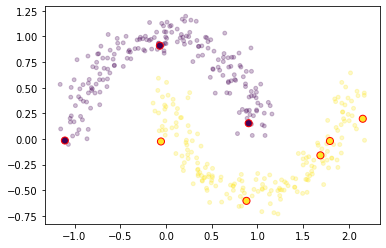

In [69]:
X, y = datasets.make_moons(500, noise=.1, random_state=42)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

test_indices = random.sample(range(X.shape[0]), k = 100)
train_indices = [i for i in range(X.shape[0]) if i not in test_indices]
labeled_indices = random.sample(train_indices, k=8)
unlabeled_indices = [i for i in train_indices if i not in labeled_indices]
labeled_ds = torch.utils.data.TensorDataset(X[labeled_indices], y[labeled_indices])
unlabeled_ds = SSLDataset(X[train_indices], y[train_indices], noise=0.15)
test_ds = torch.utils.data.TensorDataset(X[test_indices], y[test_indices])

plt.scatter(X[train_indices, 0], X[train_indices, 1], c=y[train_indices], s=15, alpha=.25)
plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y[labeled_indices], s=50, edgecolors='red')
plt.show()

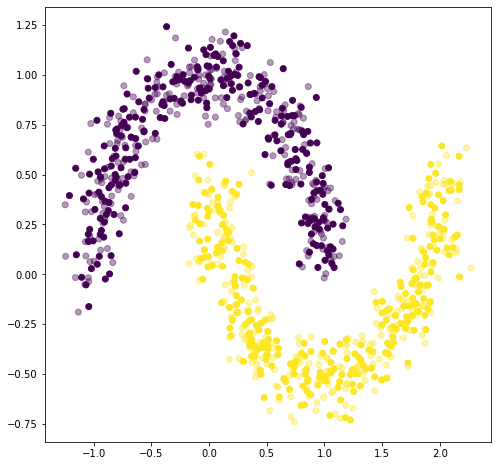

In [70]:
# What are useful values for noise?

X_trans = stochasitc_augmentation(X, 0.05)

fix = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(X_trans[:,0], X_trans[:,1], c=y, alpha=0.4)
plt.show()

In [71]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None, feature_extractor=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    if feature_extractor:
        feature_extractor.eval()
        feature_extractor.cpu()
        zz = feature_extractor(zz)
    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, s=50, edgecolors='red')
    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u, s=15, alpha=.25)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

In [72]:
class Net(nn.Module):
    def __init__(self, num_classes: int = 2, feature_dim: int = 128, projection_dim: int = 64):
        super(Net, self).__init__()
        self.base_encoder = nn.Sequential(nn.Linear(2, feature_dim), nn.ReLU())
        self.projector = nn.Sequential(nn.Linear(feature_dim, projection_dim), nn.ReLU())
        self.fc = nn.Linear(feature_dim, num_classes)


    def forward(self, x, get_projections=False):
        x = self.base_encoder(x)
        if get_projections:
            return self.projector(x)
        else:
            return self.fc(x)

In [73]:
LARGE_NUM = 1e9

class NTXent(nn.Module):
    def __init__(self, batch_size, hidden_norm: bool = True, temperature: int = 1.0, n_views: int = 2):
        super(NTXent, self).__init__()
        self.sim = nn.CosineSimilarity(dim=-1)
        self.temperature = temperature
        self.hidden_norm = hidden_norm
        self.device='cuda'
        self.ce_loss = torch.nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.n_views = n_views

    def forward(self, features):
        labels = torch.cat([torch.arange(self.batch_size) for i in range(self.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.device)

        features = nn.functional.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        logits = logits / self.temperature
        loss = self.ce_loss(logits, labels)

        return loss

In [74]:
def pretrain_one_epoch(model, optimizer, criterion, unsupervised_loader, device='cuda'):
    model.train()
    model.to(device)
    criterion.to(device)

    total_loss, n_samples = 0, 0

    # Train the epoch
    for data, _ in unsupervised_loader:
        data = torch.cat(data, dim=0)
        data = data.to(device)
        batch_size = data.shape[0]

        # Unsupervised loss
        out = model(data, get_projections=True)
        loss = criterion(out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size

        n_samples += batch_size

    return {'loss': total_loss/n_samples}

In [75]:
def train_one_epoch(model, optimizer, criterion, supervised_loader, device='cuda'):
    model.train()
    model.to(device)
    criterion.to(device)

    total_loss, n_samples, n_correct = 0, 0, 0 

    # Train the epoch
    for (x, y) in supervised_loader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]

        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size

        n_samples += batch_size

        n_correct += torch.sum(torch.max(out.softmax(-1), dim=-1)[1] == y).item()

    return {'loss':total_loss/n_samples, 'acc':n_correct/n_samples}

In [76]:
def evaluate(model, criterion, test_loader, device='cuda'):
    model.eval()
    model.to(device)
    criterion.to(device)

    total_loss, n_samples, n_correct = 0, 0, 0 

    # Train the epoch
    for (x, y) in test_loader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]

        out = model(x)
        loss = criterion(out, y)

        total_loss += loss.item() * batch_size
        n_samples += batch_size
        n_correct += torch.sum(torch.max(out.softmax(-1), dim=-1)[1] == y).item()

    return {
        'loss':total_loss/n_samples, 
        'acc':n_correct/n_samples
        }

In [77]:
#### Current Best Setting ####
n_epochs = 5000
batch_size = 128
learning_rate = 1e-1
momentum = 0.9
weight_decay = 5e-4
model_save_step = 50

n_classes = 2
feature_dim = 64
projection_dim = 64

In [78]:
## Pretrain a feature_extractor with an additional nonlinear feature transformation
n_epochs = 2000
batch_size = 64
learning_rate = 1e-1
momentum = 0.9
weight_decay = 5e-4
model_save_step = 50

n_classes = 2
feature_dim = 64
projection_dim = 64

torch.manual_seed(42)
model = Net(num_classes=n_classes, feature_dim=feature_dim, projection_dim=projection_dim)
model_state = copy.deepcopy(model.state_dict())
optimizer_fe = torch.optim.SGD(list(model.base_encoder.parameters()) + list(model.projector.parameters()), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
lr_scheduler_fe = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_fe, T_max=n_epochs)
dataloader_fe = torch.utils.data.DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True, drop_last=True)
criterion_fe = NTXent(batch_size=batch_size, temperature=1, hidden_norm=True)

history_fe = []
models = []

for i in tqdm(range(n_epochs)):
    train_stats = pretrain_one_epoch(model, optimizer_fe, criterion_fe, dataloader_fe)
    lr_scheduler_fe.step()
    history_fe.append(
        {'train_stats':train_stats}
    )
    if i % model_save_step == 0:
        models.append(copy.deepcopy(model.state_dict()))

  0%|          | 0/2000 [00:00<?, ?it/s]

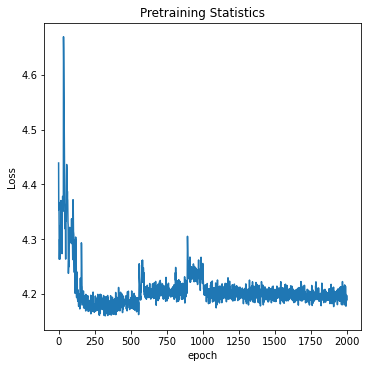

In [79]:
plt.figure(figsize=(5,5), constrained_layout=True)
plt.title("Pretraining Statistics")
plt.plot([h['train_stats']['loss'] for h in history_fe])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

In [90]:
## Train a classification layer using the extracted feature of the model above
n_epochs = 200
batch_size = 8
learning_rate = 1e-1
momentum = 0.9
weight_decay = 5e-4

best_acc = -1
best_model_dict = {}
best_history_fc = []

for j, dict in enumerate(models):
    model.load_state_dict(dict)
    optimizer_fc = torch.optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
    lr_scheduler_fc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_fc, T_max=n_epochs)
    dataloader_fc = torch.utils.data.DataLoader(labeled_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    dataloader_val = torch.utils.data.DataLoader(test_ds, batch_size=64)
    criterion_fc = nn.CrossEntropyLoss()

    history_fc = []

    for i in range(n_epochs):
        train_stats = train_one_epoch(model, optimizer_fc, criterion_fc, dataloader_fc)
        test_stats = evaluate(model, criterion_fc, dataloader_val)
        history_fc.append(
            {
            'train_stats': train_stats,
            'test_stats':test_stats
            }
        )
        lr_scheduler_fc.step()

    if test_stats['acc'] > best_acc:
        best_acc = test_stats['acc']
        best_model_dict = copy.deepcopy(model.state_dict())
        best_history_fc = copy.deepcopy(history_fc)
        print(str(j+1)+"/"+str(len(models))+" archieved "+str(best_acc)+" % Validation Accuracy, which has been trained for "+str(model_save_step*j)+"epochs.")

1/40 archieved 0.89 % Validation Accuracy, which has been trained for 0epochs.
4/40 archieved 0.94 % Validation Accuracy, which has been trained for 150epochs.
11/40 archieved 0.95 % Validation Accuracy, which has been trained for 500epochs.
13/40 archieved 0.98 % Validation Accuracy, which has been trained for 600epochs.


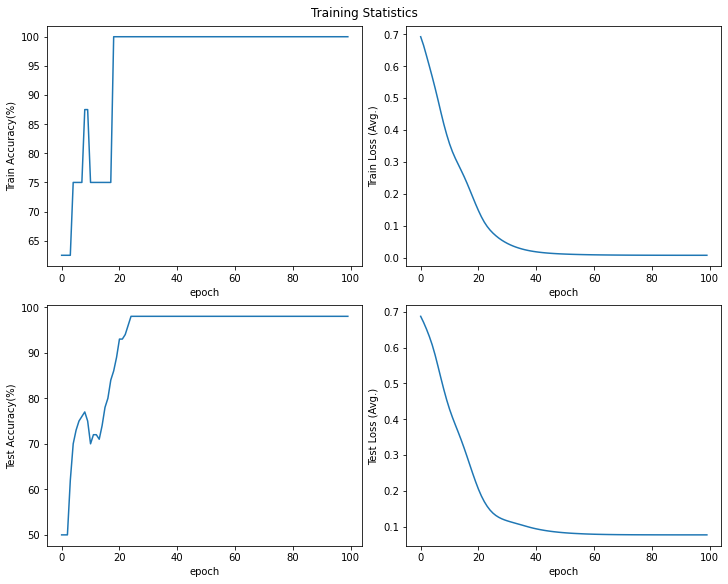

In [91]:
model.load_state_dict(best_model_dict)
history_fc = best_history_fc

fig, ax = plt.subplots(2,2, figsize=(10,8), constrained_layout=True)
fig.suptitle('Training Statistics')
ax[0][0].plot([h['train_stats']['acc']*100 for h in history_fc])
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('Train Accuracy(%)')
ax[0][1].plot([h['train_stats']['loss'] for h in history_fc])
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('Train Loss (Avg.)')

ax[1][0].plot([h['test_stats']['acc']*100 for h in history_fc])
ax[1][0].set_xlabel('epoch')
ax[1][0].set_ylabel('Test Accuracy(%)')
ax[1][1].plot([h['test_stats']['loss'] for h in history_fc])
ax[1][1].set_xlabel('epoch')
ax[1][1].set_ylabel('Test Loss (Avg.)')
plt.show()

In [92]:
## Comparison to basic NN Fully supervised training
n_epochs = 200
batch_size = 8
learning_rate = 1e-1
momentum = 0.9
weight_decay = 5e-3

baseline = Net(num_classes=n_classes, feature_dim=feature_dim, projection_dim=projection_dim)
baseline.load_state_dict(model_state)
optimizer = torch.optim.SGD(baseline.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
dataloader = torch.utils.data.DataLoader(labeled_ds, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(test_ds, batch_size=64)
criterion = nn.CrossEntropyLoss()

history = []

for i in tqdm(range(n_epochs)):
    train_stats = train_one_epoch(model=baseline, supervised_loader=dataloader, criterion=criterion, optimizer=optimizer, device='cuda')
    test_stats = evaluate(model=baseline, test_loader=dataloader_val, criterion=criterion, device='cuda')
    history.append(
        {
        'train_stats': train_stats,
        'test_stats':test_stats
        }
    )
    lr_scheduler.step()

  0%|          | 0/200 [00:00<?, ?it/s]

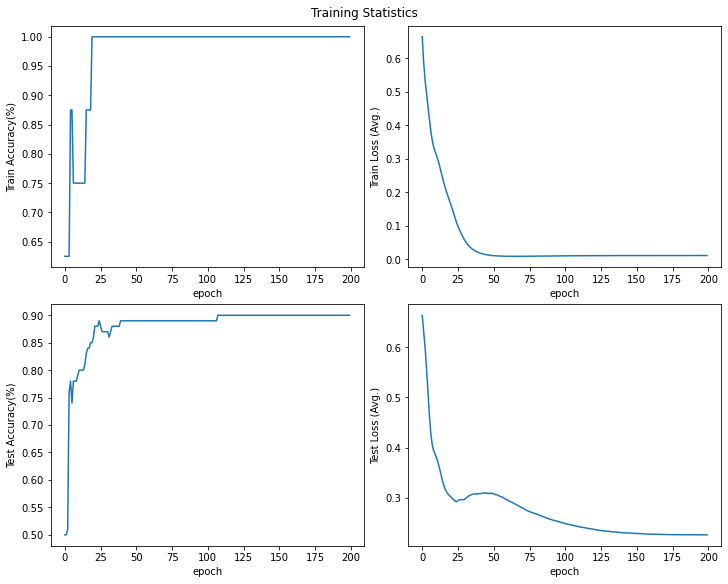

In [93]:
fig, ax = plt.subplots(2,2, figsize=(10,8), constrained_layout=True)
fig.suptitle('Training Statistics')
ax[0][0].plot([h['train_stats']['acc'] for h in history])
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('Train Accuracy(%)')
ax[0][1].plot([h['train_stats']['loss'] for h in history])
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('Train Loss (Avg.)')

ax[1][0].plot([h['test_stats']['acc'] for h in history])
ax[1][0].set_xlabel('epoch')
ax[1][0].set_ylabel('Test Accuracy(%)')
ax[1][1].plot([h['test_stats']['loss'] for h in history])
ax[1][1].set_xlabel('epoch')
ax[1][1].set_ylabel('Test Loss (Avg.)')
plt.show()

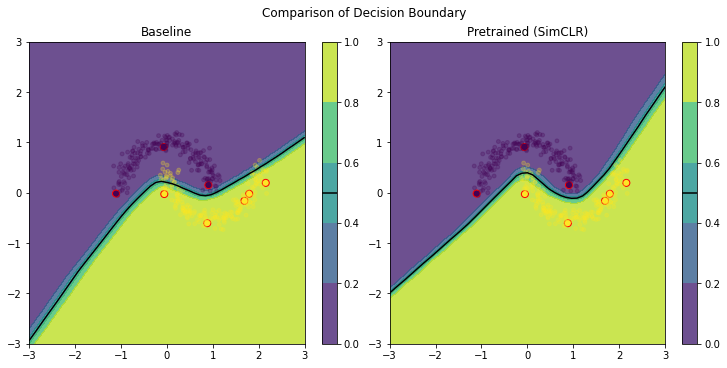

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
fig.suptitle("Comparison of Decision Boundary")
plot_contour(baseline, X[labeled_indices], y[labeled_indices], X[unlabeled_indices], y[unlabeled_indices], ax[0])
ax[0].set_title("Baseline")
plot_contour(model, X[labeled_indices], y[labeled_indices], X[unlabeled_indices], y[unlabeled_indices], ax[1])
ax[1].set_title("Pretrained (SimCLR)")
plt.show()